In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 


# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

dataset = pd.read_csv("datasets/dataset_clean.csv.gz", compression='gzip')
dataset['RIESGO_VIDA'] = np.where(dataset['RIESGO_VIDA'] == 'si', 1,0)
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
display(dataset.head(n = 5))

labels_raw = dataset[['RIESGO_VIDA']]
features_raw = dataset.drop(['RIESGO_VIDA'], axis = 1)

/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,12,16,19,20,21,22,23,24,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PET_DPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_ESTADO,PQR_TIPOATENCION,PQR_TIPOPETICION,RIESGO_VIDA,TRIM
0,bogota d.c.,de 13 a 17 años,ninguno,mujer,no aplica,bogotá,otro,no aplica,subsidiado,natural,...,bogota d.c.,bogotá,juridica,escrito,pqr,cerrado,peticion directa,reclamo,0,trim i
1,nariño,de 0 a 5 años,ninguno,hombre,no aplica,puerres,otro,no aplica,subsidiado,natural,...,nariño,puerres,natural,telefonico,pqr,cerrado,0,reclamo,0,trim i
2,valle,de 13 a 17 años,secundaria,hombre,no aplica,cali,abuelo (a),no aplica,contributivo,natural,...,valle,cali,natural,telefonico,pqr,cerrado,0,reclamo,0,trim i
3,huila,de 13 a 17 años,universitario incompleto,hombre,no aplica,neiva,padre,no aplica,contributivo,natural,...,huila,neiva,natural,personalizado,pqr,cerrado,0,reclamo,0,trim i
4,risaralda,de 13 a 17 años,ninguno,hombre,no aplica,dosquebradas,padre,persona en condición de discapacidad,contributivo,natural,...,risaralda,dosquebradas,natural,personalizado,pqr,pendiente (avance),0,reclamo,1,trim i


# Data Exploration

## Features Class Distribution

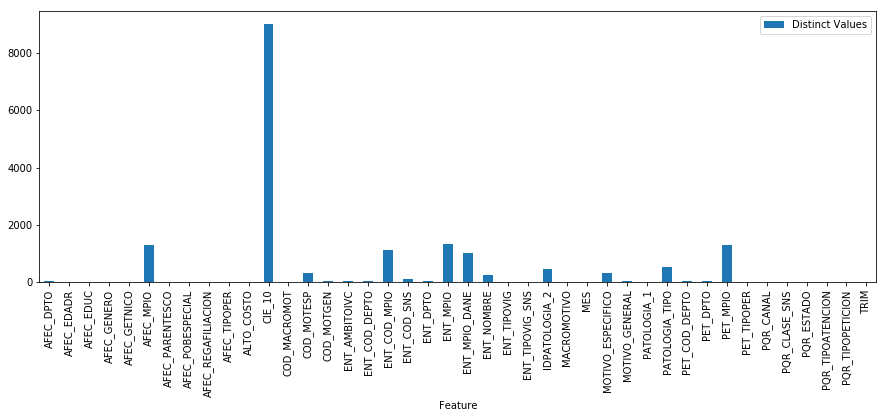

In [2]:

def getFeaturesDistribution(features):
    dfColumns = pd.DataFrame(columns=['Feature','Distinct Values'])
    for colName in features.columns.values:
        dfColumns = dfColumns.append({'Feature': colName, 'Distinct Values': features[colName].unique().size}, ignore_index=True)
    return dfColumns.infer_objects()

def showFeaturesDistribution(dfColumns):
    dfFeatures = dfColumns.copy(deep=True)
    dfFeatures.set_index("Feature",drop=True,inplace=True)
    dfFeatures.plot( kind='bar', figsize = (15,5))
dfColumns = getFeaturesDistribution(features_raw)
showFeaturesDistribution(dfColumns)


### Shared Features

Location features share the same meaning: State/City describe the same location. 

* AFEC_DPTO/AFEC_MPIO
* ENT_COD_DEPTO/ENT_COD_MPIO
* ENT_DPTO/ENT_MPIO
* PET_DPTO/PET_MPIO.

ENT_COD_DEPTO/ENT_COD_MPIO are codes for the descriptions features ENT_DPTO/ENT_MPIO, so one og the pairs can be removed from the dataset, we'll keep the codes and loose the descriptions.

Motive features are also codependent: 
* COD_MACROMOT/COD_MOTGEN/COD_MOTESP
* MACROMOTIVO/MOTIVO_GENERAL/MOTIVO_ESPECIFICO

COD_MACROMOT/COD_MOTGEN/COD_MOTESP are codes for the descriptions features MACROMOTIVO/MOTIVO_GENERAL/MOTIVO_ESPECIFICO, so one of the tuples can be removed from the dataset, we'll keep the codes and loose the descriptions.

In [3]:
#Merging Shared Features

#features_raw.apply (lambda row: merge_features (row),axis=1)
features_raw['AFEC_LOCATION'] = features_raw['AFEC_DPTO'] + features_raw['AFEC_MPIO']
features_raw['ENT_LOCATION'] = features_raw['ENT_COD_DEPTO'] + features_raw['ENT_COD_MPIO']
features_raw['PET_LOCATION'] = features_raw['PET_DPTO'] + features_raw['PET_MPIO']
features_raw['COMPLETE_MOTIVE'] = features_raw['COD_MACROMOT'] + features_raw['COD_MOTGEN'] + features_raw['COD_MOTESP']
# Removing redundant features
features_raw = features_raw.drop(['ENT_DPTO', 'ENT_MPIO','MACROMOTIVO', 'MOTIVO_GENERAL', 'MOTIVO_ESPECIFICO','AFEC_DPTO', 'AFEC_MPIO', 'ENT_COD_DEPTO', 'ENT_COD_MPIO', 'PET_DPTO', 'PET_MPIO', 'COD_MACROMOT', 'COD_MOTGEN', 'COD_MOTESP'], axis = 1)

display()


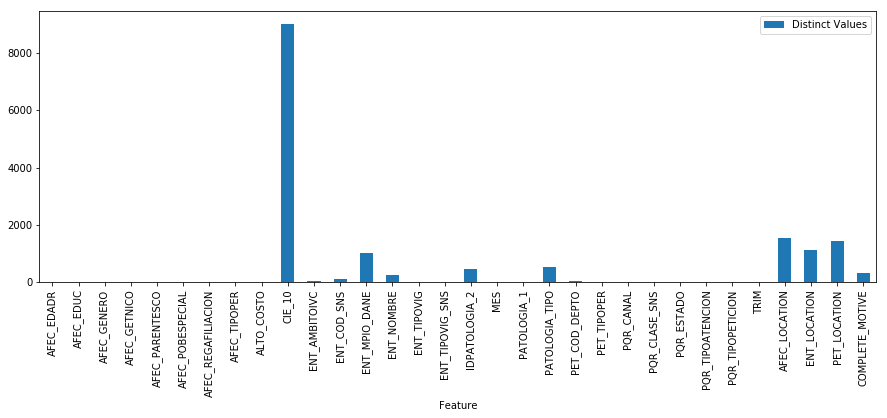

In [4]:
dfColumns = getFeaturesDistribution(features_raw)
showFeaturesDistribution(dfColumns)

In [5]:
features_raw = features_raw.applymap(str)


In [6]:
from __future__ import division
# TODO: Total number of records
n_records = dataset['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is at risk
life_risk = dataset[dataset["RIESGO_VIDA"] == 1]
n_life_risk = life_risk['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is not at risk
no_life_risk =  dataset[dataset["RIESGO_VIDA"] == 0]
n_no_life_risk = no_life_risk['RIESGO_VIDA'].count()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_life_risk/n_records)*100

# Print the results
print "Total number of records: {:,}".format(n_records)
print "Individuals with life at risk: {:,}".format(n_life_risk)
print "Individuals with life not at risk: {:,}".format(n_no_life_risk)
print "Percentage of individuals with life at risk: {:.2f}%".format(greater_percent)

Total number of records: 2,130,783
Individuals with life at risk: 288,811
Individuals with life not at risk: 1,841,972
Percentage of individuals with life at risk: 13.55%


## Encoding dataset

All features in the dataset are categorical. Some of them have too many classes to be one hot encoded. Mean encoding transformation will be perform on the dataset to encode features instead hot encoding it.

In [7]:
features_columns = features_raw.columns.values.tolist()

In [8]:
from category_encoders import *
import time


start_time = time.time()   
enc = TargetEncoder(cols=features_raw.columns.values.tolist(), return_df = True).fit(features_raw, labels_raw)
dataset_encoded = enc.transform(features_raw)
print("--- %s seconds ---" % (time.time() - start_time))

display(dataset_encoded.head(n = 5))  


--- 2370.07926083 seconds ---


,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,ALTO_COSTO,CIE_10,...,PQR_CANAL,PQR_CLASE_SNS,PQR_ESTADO,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM,AFEC_LOCATION,ENT_LOCATION,PET_LOCATION,COMPLETE_MOTIVE
0,0.262627,0.179425,0.187490,0.217272,0.264173,0.204179,0.280688,0.200446,0.129512,0.061950,...,0.074075,0.240487,0.065705,0.081491,0.2386,0.131762,0.171294,0.170139,0.175821,0.255345
1,0.278952,0.179425,0.219439,0.217272,0.264173,0.204179,0.280688,0.200446,0.129512,0.090751,...,0.084191,0.240487,0.065705,0.164131,0.2386,0.131762,0.163793,0.126582,0.106796,0.156412
2,0.262627,0.210089,0.219439,0.217272,0.319044,0.204179,0.178150,0.200446,0.129512,0.384615,...,0.084191,0.240487,0.065705,0.164131,0.2386,0.131762,0.231316,0.211707,0.195326,0.230204
3,0.262627,0.315311,0.219439,0.217272,0.308624,0.204179,0.178150,0.200446,0.129512,0.016157,...,0.466574,0.240487,0.065705,0.164131,0.2386,0.131762,0.334056,0.345899,0.261161,0.104876
4,0.262627,0.179425,0.219439,0.217272,0.308624,0.386519,0.178150,0.200446,0.129512,0.795501,...,0.466574,0.240487,0.996180,0.164131,0.2386,0.131762,0.217398,0.213673,0.164382,0.285007


In [9]:

# Log-transform the skewed features
skewed = features_columns
features_log_transformed = dataset_encoded.apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
display(features_log_transformed.head(n = 2))
#distribution(features_log_transformed, transformed = True)

,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,ALTO_COSTO,CIE_10,...,PQR_CANAL,PQR_CLASE_SNS,PQR_ESTADO,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM,AFEC_LOCATION,ENT_LOCATION,PET_LOCATION,COMPLETE_MOTIVE
0,0.233195,0.165027,0.171842,0.196613,0.234418,0.185798,0.247397,0.182693,0.121786,0.060107,...,0.071460,0.215504,0.063637,0.078341,0.213982,0.123776,0.158109,0.157122,0.161967,0.227410
1,0.246041,0.165027,0.198391,0.196613,0.234418,0.185798,0.247397,0.182693,0.121786,0.086867,...,0.080834,0.215504,0.063637,0.151975,0.213982,0.123776,0.151685,0.119189,0.101469,0.145322


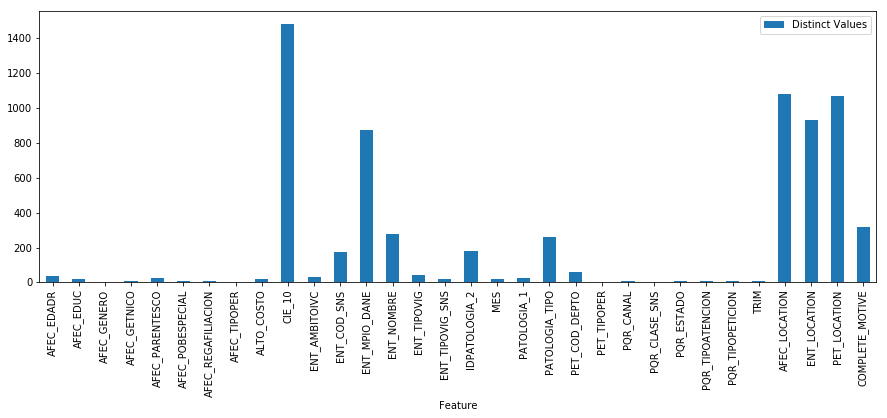

In [10]:

# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import QuantileTransformer

# Initialize a scaler, then apply it to the features
scaler = QuantileTransformer() # default=(0, 1)


features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[features_columns] = scaler.fit_transform(features_log_transformed[features_columns])

#distribution(features_log_minmax_transform, transformed = True)
# Show an example of a record with scaling applied
dfLogColumns = getFeaturesDistribution(features_log_minmax_transform)
showFeaturesDistribution(dfLogColumns)

# Store Dataset

In [11]:
features_log_minmax_transform['RIESGO_VIDA'] = dataset['RIESGO_VIDA']
features_log_minmax_transform.to_csv("datasets/dataset.csv.gz", encoding='utf-8', compression = 'gzip')

# Resampling

Target classes are highly unbalanced

0    1841972
1    288811 
Name: RIESGO_VIDA, dtype: int64


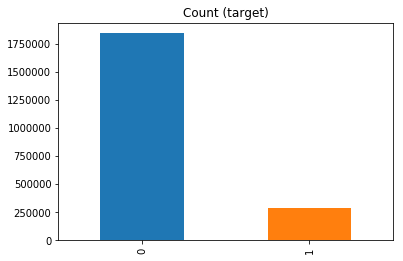

In [ ]:
target_count = dataset['RIESGO_VIDA'].value_counts()
print(target_count)
target_count.plot(kind='bar', title='Count (target)');

In [ ]:
from imblearn.under_sampling import AllKNN

rus = AllKNN(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(features_log_minmax_transform, dataset['RIESGO_VIDA'])

print('Removed indexes:', id_rus)


## Storing removed records for future model validation

In [ ]:
X_rus = pd.DataFrame(np.array(X_rus), columns=features_log_minmax_transform.columns.values.tolist())
y_rus = pd.DataFrame(np.array(y_rus), columns=['RIESGO_VIDA'])


dataset_rus = X_rus
dataset_rus['RIESGO_VIDA'] = y_rus

dataset_rus = pd.concat([features_log_minmax_transform,dataset_rus]).drop_duplicates(keep=False)

display(dataset_rus.head(n = 3))

dataset_rus.to_csv("datasets/dataset_under_sampled_validation.csv.gz", encoding='utf-8', compression = 'gzip')

In [ ]:
target_count_rus = y['RIESGO_VIDA'].value_counts()
print(target_count_rus)
target_count_rus.plot(kind='bar', title='Count (target)');

In [ ]:
X_rus['RIESGO_VIDA'] = y_rus['RIESGO_VIDA']
X_rus.to_csv("datasets/dataset_under_sampled.csv.gz", encoding='utf-8', compression = 'gzip')

## Over Sampling

In [12]:
# Split the dataset to leave a separate dataset to verify the Over Sampled dataset is not overfitting
# Import train_test_split
from sklearn.model_selection import train_test_split

XOS_set, XOS_validation, yOS_set, yOS_validation = train_test_split(features_log_minmax_transform, 
                                                    dataset['RIESGO_VIDA'], 
                                                    test_size = 0.10, 
                                                    random_state = 10)

print "Training set has {} samples.".format(XOS_set.shape[0])
print "Validation set has {} samples.".format(XOS_validation.shape[0])


from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 'not majority')
X_ros, y_ros = ros.fit_sample(XOS_set, yOS_set)

print(X_ros.shape[0] - XOS_set.shape[0], 'new random picked points')


Training set has 1917704 samples.
Validation set has 213079 samples.
(1397888, 'new random picked points')


In [13]:
X_ros = pd.DataFrame(np.array(X_ros), columns=features_log_minmax_transform.columns.values.tolist())
y_ros = pd.DataFrame(np.array(y_ros), columns=['RIESGO_VIDA'])

1    1657796
0    1657796
Name: RIESGO_VIDA, dtype: int64


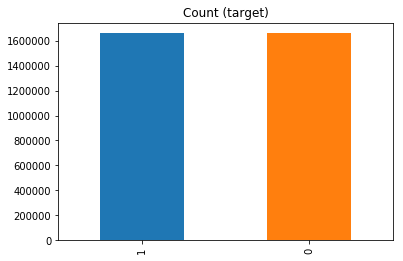

In [14]:
target_count_ros = y_ros['RIESGO_VIDA'].value_counts()
print(target_count_ros)
target_count_ros.plot(kind='bar', title='Count (target)');

In [26]:
X_ros['RIESGO_VIDA'] = y_ros[['RIESGO_VIDA']]
X_ros.to_csv("datasets/dataset_over_sampled.csv.gz", encoding='utf-8', compression = 'gzip')

XOS_validation['RIESGO_VIDA'] = pd.DataFrame(yOS_validation, columns = ['RIESGO_VIDA'])
XOS_validation.to_csv("datasets/dataset_over_sampled_validation.csv.gz", encoding='utf-8', compression = 'gzip')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
